# Potential References:

[Sales Prediction with XGBoost](https://github.com/NinoRisteski/Sales-Prediction-with-XGBoost/blob/main/Sales_Prediction_with_XGBoost.ipynb) (used an XGBoost model to create a prediction system that estimates the sales of a given product using item price, weight, type, the outlet it was sold at, and the actual sales as X and Y respectively)

# Model Conceptualization

Model type: XGBoost, would be trained on the shuffled datasets to make sure that overfitting to provided data is less likely to occur

X set:

* Collection of reviews for the listed movies + their sentiment scores

Y set: Could either be:


*   The overall gross of a movie at that given week the review was made
*   The recorded change in movie revenue from the previous week at the time the review was made

20 movies will be used in training, 5 movies will be used in testing, all movies will be from 2024

Review set will contain:

* reg_index (index of the given post in the set)
* datetime (date and time post was made)
* comments (the comments left on the post)
* text (the text value of the post)
* matched_title (what movie title was matched to the given post)
* sentiment_score (the estimated sentiment towards the movie)

Movie set will contain:
* Date (weekend date for the given movie)
* Movie_title (title of movie)
* Gross (revenue that the movie made for the given weekend)
* Lw% (change in revenue from the last weekend)
* Total_Gross (total revenue recorded up to that point)
* WeekendsInRelease (how many weekends since debut)

In [ ]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GroupKFold

Load data and inspect the first few rows

In [ ]:
# Read in the datasets from .csv files
df = pd.read_csv('Model_Training_Set_v3.csv')

#convert datetime column into datetime value
df['Weekend_of'] = pd.to_datetime(df['Weekend_of'])

#sort by date in ascending order
df = df.sort_values(by='Weekend_of')
#df_numeric = df_numeric.sort_values(by='datetime')

#print the first few rows and info about the datasets
print("Dataset head:")
print(f"{df.head()}")
#print("\nDataset info:")
#print(f"{df_oridinal.info()} {df_numeric.info()}")

Dataset head:
    matched_title  total_sentiment_score Weekend_of  comment_count  \
0   Asteroid City                 48.036 2023-06-16           75.0   
1       Elemental                172.080 2023-06-16         2069.0   
2  The Blackening                 13.940 2023-06-16          227.0   
3       The Flash                127.261 2023-06-16         7236.0   
4   Asteroid City                143.572 2023-06-23         1836.0   

   post_count     Gross  TotalGross   %LW  post_density  comment_density  \
0           1    853382      853382  0.00      0.034483         0.007807   
1          10  29602429    29602429  0.00      0.344828         0.215364   
2           5   6013131     6013131  0.00      0.172414         0.023629   
3          13  55043679    55043679  0.00      0.448276         0.753201   
4           9   9053265    10267979  9.61      0.333333         0.632014   

   comment_post_ratio  total_posts  total_comments  
0           75.000000           29          9607.0  
1 

Define features (X set) and target (y set).
And split data into training and testing sets.

In [ ]:
#define X and y
#drop features that may encode out target
X = df.drop(columns=['matched_title', 'Weekend_of', 'Gross', 'TotalGross', '%LW'])
y = df['Gross']

Train an initial XGBoost model

In [ ]:
#set up the regression model
xgb_reg = xgb.XGBRegressor(max_depth = 5,
                                   n_estimators = 1000,
                                   learning_rate = 0.1,
                                   seed = 42, objective='reg:squarederror',
                                   random_state=42,
                                   early_stopping_rounds=20)

# Split the datasets into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

#train the model using early stopping
xgb_reg.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    #early_stopping_rounds=20,
    #verbose=True
)


#make predictions on the validation set and evaluate performance
y_val_pred = xgb_reg.predict(X_test)
val_rmse = np.sqrt(mean_squared_error(y_test, y_val_pred))
r2_val = r2_score(y_test, y_val_pred)

# See about RMSE R

print("\nInitial XGBppst Model Performance on Validation Set:")
print(f"Validation RMSE: {val_rmse:.2f}")
print(f"Validation R^2: {r2_val:.2f}")


[0]	validation_0-rmse:11617146.60654
[1]	validation_0-rmse:11430941.38433
[2]	validation_0-rmse:11288518.67058
[3]	validation_0-rmse:11030565.73964
[4]	validation_0-rmse:10820322.33832
[5]	validation_0-rmse:10705894.14756
[6]	validation_0-rmse:10510131.03947
[7]	validation_0-rmse:10440572.35965
[8]	validation_0-rmse:10307214.75001
[9]	validation_0-rmse:10214209.58893
[10]	validation_0-rmse:10153940.67397
[11]	validation_0-rmse:10074537.93587
[12]	validation_0-rmse:10021810.94359
[13]	validation_0-rmse:9985684.63308
[14]	validation_0-rmse:9938735.06230
[15]	validation_0-rmse:9953567.64320
[16]	validation_0-rmse:9930689.03759
[17]	validation_0-rmse:9844588.81478
[18]	validation_0-rmse:9846931.05024
[19]	validation_0-rmse:9764040.13766
[20]	validation_0-rmse:9782718.25592
[21]	validation_0-rmse:9777603.15080
[22]	validation_0-rmse:9808128.72936
[23]	validation_0-rmse:9809987.62733
[24]	validation_0-rmse:9857409.83064
[25]	validation_0-rmse:9855958.08135
[26]	validation_0-rmse:9893816.4028

Analysis of the model performance on validation set:


*   Validation RMSE: This value indicates that, on average, the model's predictions deviate from the actual values by about 1.2 million.
*   Validation R^2: This means that 97% of the variance in the weekly revenue is explained by the model. This indicates a strong relationship between our model's features and the target variable.



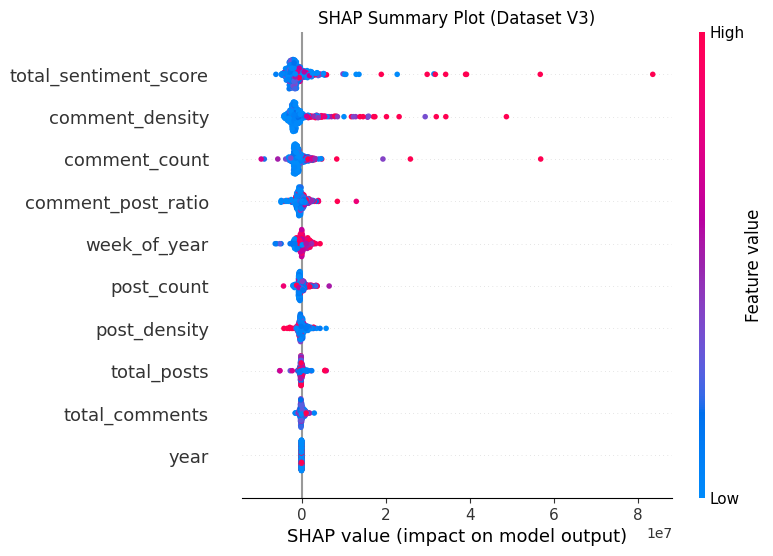

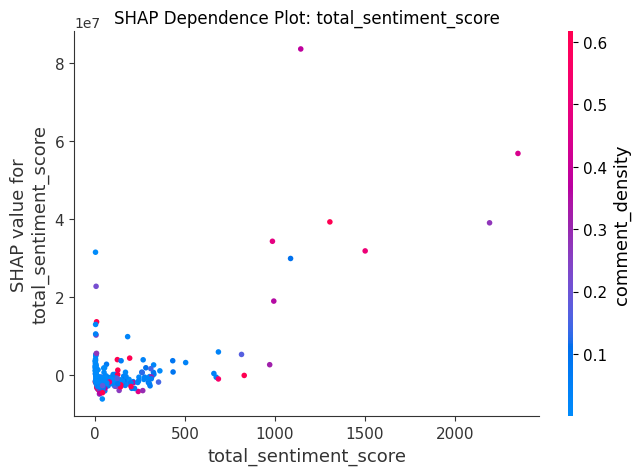

In [ ]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from xgboost import XGBRegressor

# Load & preprocess as before...
df = pd.read_csv('/content/Model_Training_Set_v3.csv')
df['matched_title'] = df['matched_title'].astype('category')
df['Weekend_of'] = pd.to_datetime(df['Weekend_of'])
df['week_of_year'] = df['Weekend_of'].dt.isocalendar().week.astype(int)
df['year'] = df['Weekend_of'].dt.year.astype(int)

X = df.drop(columns=['Gross','matched_title', 'Weekend_of', 'TotalGross', '%LW'])
y = df['Gross']

# Final model (assuming already trained, or retrain)
model = xgb.XGBRegressor(max_depth = 5, n_estimators = 1000, learning_rate =
                         0.1,
                         seed = 42,
                         objective='reg:squarederror',
                         random_state=42,
                         #early_stopping_rounds=20
                         )
model.fit(X, y)

# CPU-only SHAP explainer
explainer = shap.TreeExplainer(model, feature_perturbation="tree_path_dependent")
shap_values = explainer.shap_values(X)

# Summary plot
shap.summary_plot(shap_values, X, show=False)
plt.title("SHAP Summary Plot (Dataset V3)")
plt.show()

# Dependence for top feature
mean_abs_shap = np.abs(shap_values).mean(axis=0)
top_idx = np.argmax(mean_abs_shap)
top_feature = X.columns[top_idx]

shap.dependence_plot(top_feature, shap_values, X, show=False)
plt.title(f"SHAP Dependence Plot: {top_feature}")
plt.show()

Hyperparameter tuning:
TimeSeriesSplit is a variant of cross-validation specifically designed for time-series data where the order of observations matters. Unlike standard k-fold cross-validation—where data is split into random folds that might violate the temporal order—TimeSeriesSplit maintains the sequence of the data, ensuring that future data never leaks into the training set when evaluating the model.

In [ ]:
#use TimeSeriesSplit to ensure that training/validation splits respect temporal order
tscv = TimeSeriesSplit(n_splits=5)

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 1.0]
}

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

#GridSearchCV with TimeSeriesSplit with preserve order while performing cross-validation
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=tscv,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
print("\nBest Hyperparameters:")
print(grid_search.best_params_)


Fitting 5 folds for each of 54 candidates, totalling 270 fits

Best Hyperparameters:
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


Use the best hyperparameters for the final predictions

In [ ]:
final_model = grid_search.best_estimator_
y_test_pred = final_model.predict(X_test)

rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_test = r2_score(y_test, y_test_pred)

print("\nFinal Model Performance on Test Set:")
print(f"Test RMSE: {rmse_test:.2f}")
print(f"Test R^2: {r2_test:.2f}")



Final Model Performance on Test Set:
Test RMSE: 9415707.12
Test R^2: 0.37


Visualize predictions vs. actual values

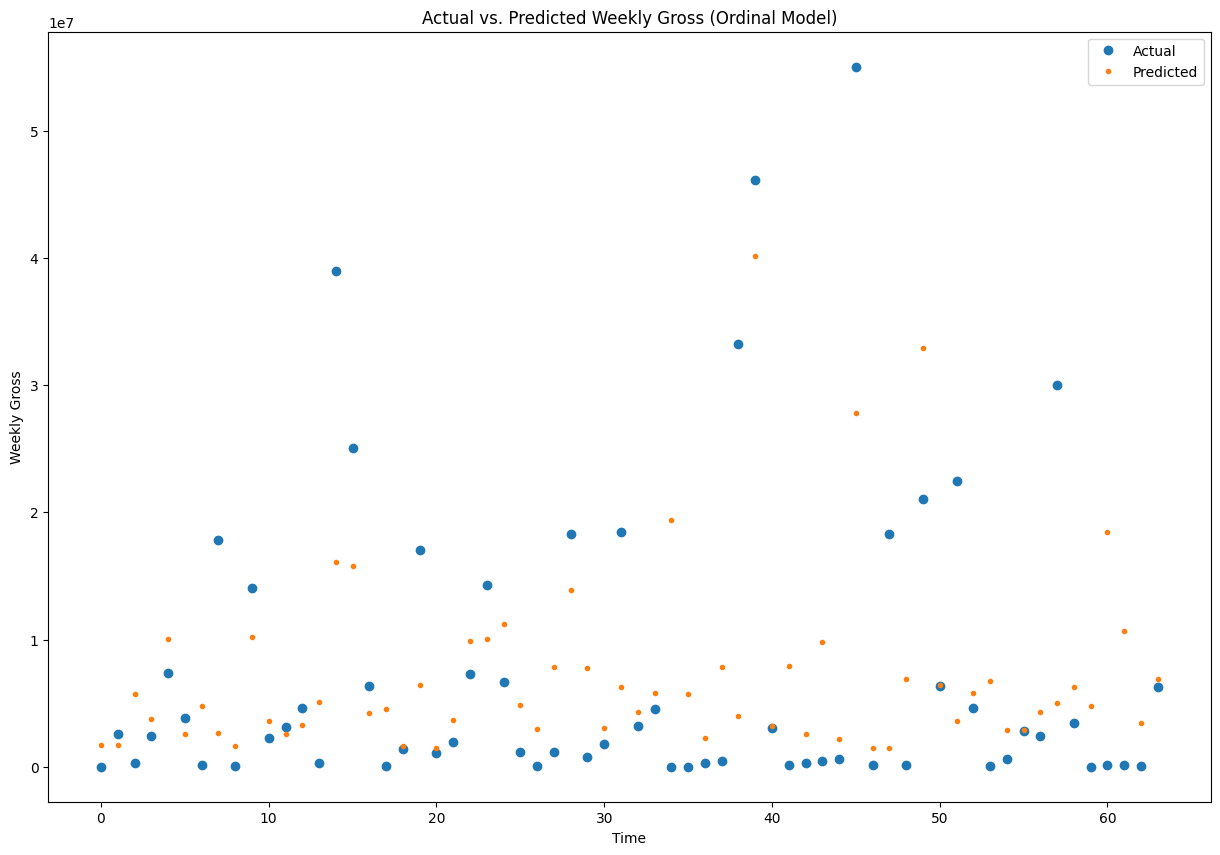

0.6270934498046875


In [ ]:
# Plot the test set vs the predictions from the oridinal data
plt.figure(figsize=(15, 10))
plt.plot(y_test.values, label='Actual', marker='o', linestyle='None')
plt.plot(y_test_pred, label='Predicted', marker='.', linestyle='None')
plt.xlabel('Time')
plt.ylabel('Weekly Gross')
plt.title('Actual vs. Predicted Weekly Gross (Ordinal Model)')
plt.legend()
plt.show()

# Calculate the average difference in value between actual and predicted gross as a percentage
diff_sum = 0
for i in range(len(y_test.values)):
    diff_sum += abs(y_test.values[i] - y_test_pred[i])/10000000
print(diff_sum/len(y_test.values))
